# Применение библиотеки Tensor Flow Probability для анализа структурных временных рядов

Для анализа использутеся модуль tfp.sts. Он отличается построением Байесовских моделей структурных временных рядов.

"Байесовский метод" в общем смысле заключается в добавлении шума в модель, для того, чтобы избежать ее переобучения. "Байесовский метод" применяется не только к моделям временных рядов, но и, например, для создания Байесовских нейронных сетей (BNN).

In [127]:
import seaborn as sns
import matplotlib.dates as mdates

import numpy as np
import pandas as pd
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

from tensorflow_probability import distributions as tfd
from tensorflow_probability import sts

tf.enable_v2_behavior()

%matplotlib inline
import matplotlib as mpl
from matplotlib import pylab as plt

import collections


In [128]:
if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')
else:
  print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

SUCCESS: Found GPU: /device:GPU:0


In [129]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project workshop/2 sprint/Datasets/1019168_190.csv', delimiter = ',')

df

,time,ta_id,blockID,blockDur,t_trp,b_trp,real_time
0,2018/01/01 05,190.0,60273318.0,240.0,1.038,0.944,2018-01-01 05:19:30
1,2018/01/01 05,190.0,60273319.0,240.0,0.836,0.752,2018-01-01 05:43:00
2,2018/01/01 06,190.0,60273320.0,240.0,0.791,0.671,2018-01-01 06:06:30
3,2018/01/01 06,190.0,60273297.0,240.0,0.455,0.371,2018-01-01 06:49:24
4,2018/01/01 07,190.0,60273299.0,180.0,0.527,0.454,2018-01-01 07:07:48
...,...,...,...,...,...,...,...
92877,2022/06/06 01,190.0,269922854.0,240.0,0.596,0.356,2022-06-06 01:00:15
92878,2022/06/06 01,190.0,269922863.0,240.0,0.689,0.392,2022-06-06 01:27:20
92879,2022/06/06 01,190.0,269922864.0,240.0,0.610,0.338,2022-06-06 01:43:40
92880,2022/06/06 02,190.0,269922865.0,180.0,0.541,0.306,2022-06-06 02:14:20


In [130]:
df['date'] = pd.to_datetime(pd.to_datetime(df['real_time']).dt.date)

# df.info()

In [131]:
df_use = df[df['real_time'].between('2021-05-31 00:00:00', '2022-06-03 00:00:00', inclusive='both')].drop(columns='time')

# df_use #датасет в используемых датах + некоторое время вперед и назад для корректной интерполяции данных на границах

In [132]:
gen = pd.date_range('2021-05-31 00:00:00', '2022-06-03 00:00:00', freq='H')

In [133]:
time_new = pd.concat([df_use['real_time'], pd.Series(gen)], ignore_index=True, sort=True)

# time_new #колонка времени, скомбинированная из колонки времени начального датасета и сгенерированных дат

In [134]:
df_full = df_use.merge(pd.Series(time_new, name='time'), left_on='real_time', right_on='time', how='right') \
                .drop(columns='real_time').astype({'time':'datetime64'}).sort_values(by='time').reset_index(drop=True)

# df_full #датасет с колонкой времени, сотсавленной из начальных дат и сгенерированных

In [135]:
df_full['int'] = df_full['t_trp'].interpolate(metod='time')

df_full = df_full[df_full['time'].between('2021-05-31 23:00:00', '2022-05-31 23:00:00', inclusive='both')]

# df_full #датасет с интерполяцией данных по t_trp на строки с временем 00:00:00

In [136]:
df_res = df_full.loc[pd.isna(df_full['date']) == True].drop(columns={'ta_id', 'blockID', 'blockDur', 't_trp', 'b_trp', 'date'}) \
                                                      .rename(columns={'int':'t_trp'}).reset_index(drop=True)

df_res = df_res[df_res['time'].between('2021-11-30 00:00:00', '2022-05-31 23:00:00', inclusive='both')] 

# dt_date = df_res['time'].to_numpy() #конвертируем дс в nparrey по времени и фиче
# dt_value = df_res['t_trp'].to_numpy()

# df_res #ресемплированный датасет из t_trp и времени. Используется для построения графика и для обучения.

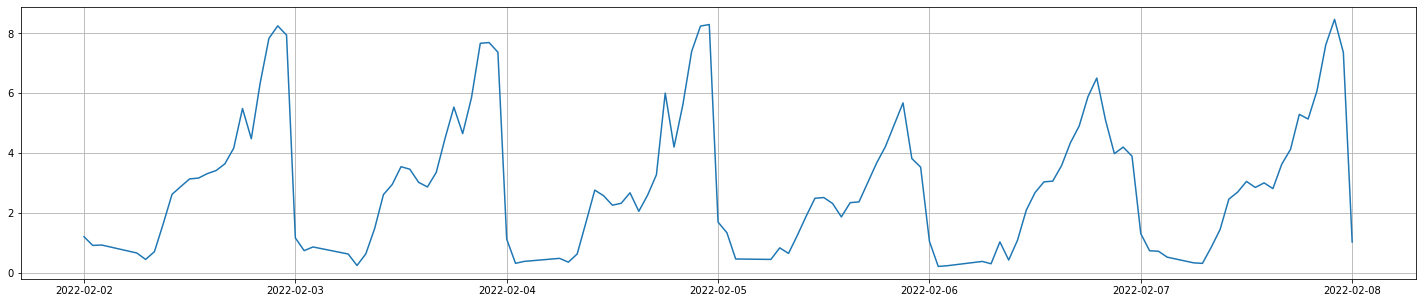

In [137]:
start_date = '2022-02-02 00:00:00'
end_date = '2022-02-08 00:00:00'
observation_dates = df_res['time'].between(start_date, end_date, inclusive='both')

fig, ax = plt.subplots(1, 1, figsize=(25, 5))
plt.plot(df_res[observation_dates].time, df_res[observation_dates].t_trp)
plt.grid(True, which='both')

plt.show()

In [138]:
num_train_starts = 0
num_forecast_steps = 31*24*2 #общее колчиество отметок времени в прогнозе
num_forecast_steps_vs_real = 31*24 #колчиество отметок времени в прогнозе для сравнения с реальностью

forecast_start = df_res['time'].iloc[-num_forecast_steps_vs_real].to_numpy() #дата и время начала прогноза

num_forecast_steps

1488

In [139]:
train_dt = df_res['t_trp'].iloc[num_train_starts:-num_forecast_steps].to_numpy() #тренировочные данные

train_dt_info = df_res['t_trp'].iloc[num_train_starts:-num_forecast_steps] #тоже, что в верхней строчке, только для выведения инфо

# train_dt_info

In [140]:
def build_model(observed_time_series):
  hour_of_day = sts.Seasonal(
      num_seasons = 24, num_steps_per_season=1,
      observed_time_series=observed_time_series,
      name='hour_of_day')
  day_of_week = sts.Seasonal(
      num_seasons = 7, num_steps_per_season=24,
      observed_time_series=observed_time_series,
      name='day_of_week')
  month_of_year = sts.Seasonal(
      num_seasons = 12, num_steps_per_season=24*7*4,
      observed_time_series=observed_time_series,
      name='month_of_year')
  model = sts.Sum([hour_of_day, day_of_week, month_of_year], observed_time_series=observed_time_series)
  return model

In [141]:
t_trp_model = build_model(train_dt)

variational_posteriors = tfp.sts.build_factored_surrogate_posterior(
    model=t_trp_model)

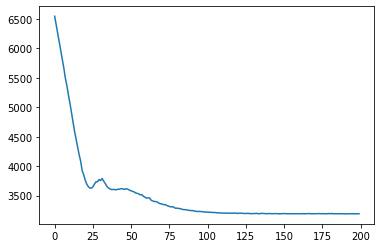

In [142]:
num_variational_steps = 200
num_variational_steps = int(num_variational_steps)

elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
        target_log_prob_fn=t_trp_model.joint_distribution(
            observed_time_series=train_dt).log_prob,
        surrogate_posterior=variational_posteriors, 
        optimizer=tf.optimizers.Adam(learning_rate=0.1), 
        num_steps=num_variational_steps,
        jit_compile=True)

plt.plot(elbo_loss_curve)
plt.show()

In [143]:
q_samples = variational_posteriors.sample(50)

In [144]:
print("Inferred parameters:")
for param in t_trp_model.parameters:
  print("{}: {} +- {}".format(param.name,
                              np.mean(q_samples[param.name], axis=0),
                              np.std(q_samples[param.name], axis=0)))

Inferred parameters:
observation_noise_scale: 0.6067384738251484 +- 0.009000727510925434
hour_of_day/_drift_scale: 0.13475277123928664 +- 0.006774683687205799
day_of_week/_drift_scale: 0.46567317828669197 +- 0.04178634309865467
month_of_year/_drift_scale: 0.2894879286980231 +- 0.8686348189441017


In [145]:
def plot_forecast(x, y,
                  forecast_mean, forecast_scale, forecast_samples,
                  title, x_locator=None, x_formatter=None):
  """Plot a forecast distribution against the 'true' time series."""
  colors = sns.color_palette()
  c1, c2 = colors[0], colors[1]
  fig = plt.figure(figsize=(300, 15))
  ax = fig.add_subplot(1, 1, 1)

  plt.grid(True, which='both')

  num_steps = len(y)
  num_steps_forecast = forecast_mean.shape[-1]
  num_steps_train = num_steps - num_forecast_steps_vs_real


  ax.plot(x, y, lw=2, color=c1, label='ground truth')

  forecast_steps = np.arange(
      x[num_steps_train],
      x[num_steps_train]+pd.to_timedelta(num_steps_forecast, unit='h'),
      np.timedelta64(1, "h"),
      dtype=x.dtype)

  ax.plot(forecast_steps, forecast_samples.T, lw=1, color=c2, alpha=0.1)

  ax.plot(forecast_steps, forecast_mean, lw=2, ls='--', color=c2,
           label='forecast')

  ymin, ymax = min(np.min(forecast_samples), np.min(y)), max(np.max(forecast_samples), np.max(y))
  yrange = ymax-ymin
  ax.set_ylim([ymin - yrange*0.1, ymax + yrange*0.1])
  ax.set_title("{}".format(title))
  ax.legend()

  if x_locator is not None:
    ax.xaxis.set_major_locator(x_locator)
    ax.xaxis.set_major_formatter(x_formatter)
    fig.autofmt_xdate()

  return fig, ax

In [146]:
loc = mdates.HourLocator(interval=24)
fmt = mdates.DateFormatter('%Y-%m-%d')

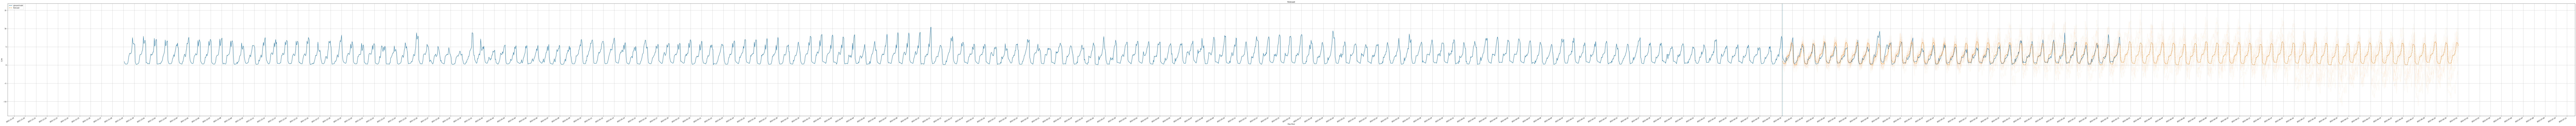

In [153]:
forecast = tfp.sts.forecast(
    t_trp_model,
    observed_time_series=train_dt,
    parameter_samples=q_samples,
    num_steps_forecast=num_forecast_steps)

num_samples = 10

forecast_mean, forecast_scale, forecast_samples = (
    forecast.mean().numpy()[..., 0],
    forecast.stddev().numpy()[..., 0],
    forecast.sample(num_samples).numpy()[..., 0]
    )

fig, ax = plot_forecast(
    df_res.time.to_numpy(), df_res.t_trp.to_numpy(),
    forecast_mean, forecast_scale, forecast_samples, 
    x_locator=loc, x_formatter=fmt, 
    title="Forecast")
ax.axvline(forecast_start, linestyle="--")
ax.legend(loc="upper left")
ax.set_ylabel("t_trp")
ax.set_xlabel("Day-Hour")
fig.autofmt_xdate()

In [154]:
# Декомпозиция модели на тренд и сезон
component_dists = sts.decompose_by_component(
    t_trp_model,
    observed_time_series=df_res.t_trp.to_numpy(),
    parameter_samples=q_samples)

In [159]:
component_means_, component_stddevs_ = (
    {k.name: c.mean() for k, c in component_dists.items()},
    {k.name: c.stddev() for k, c in component_dists.items()})

In [160]:
def plot_components(dates,
                    component_means_dict,
                    component_stddevs_dict,
                    x_locator=None,
                    x_formatter=None):
  """Plot the contributions of posterior components in a single figure."""
  colors = sns.color_palette()
  c1, c2 = colors[0], colors[1]

  axes_dict = collections.OrderedDict()
  num_components = len(component_means_dict)
  fig = plt.figure(figsize=(48, 10 * num_components))
  for i, component_name in enumerate(component_means_dict.keys()):
    component_mean = component_means_dict[component_name]
    component_stddev = component_stddevs_dict[component_name]

    ax = fig.add_subplot(num_components,1,1+i)
    ax.plot(dates, component_mean, lw=2)
    ax.fill_between(dates,
                     component_mean-2*component_stddev,
                     component_mean+2*component_stddev,
                     color=c2, alpha=0.5)
    ax.set_title(component_name)
    if x_locator is not None:
      ax.xaxis.set_major_locator(x_locator)
      ax.xaxis.set_major_formatter(x_formatter)
    axes_dict[component_name] = ax
  fig.autofmt_xdate()
  fig.tight_layout()
  return fig, axes_dict

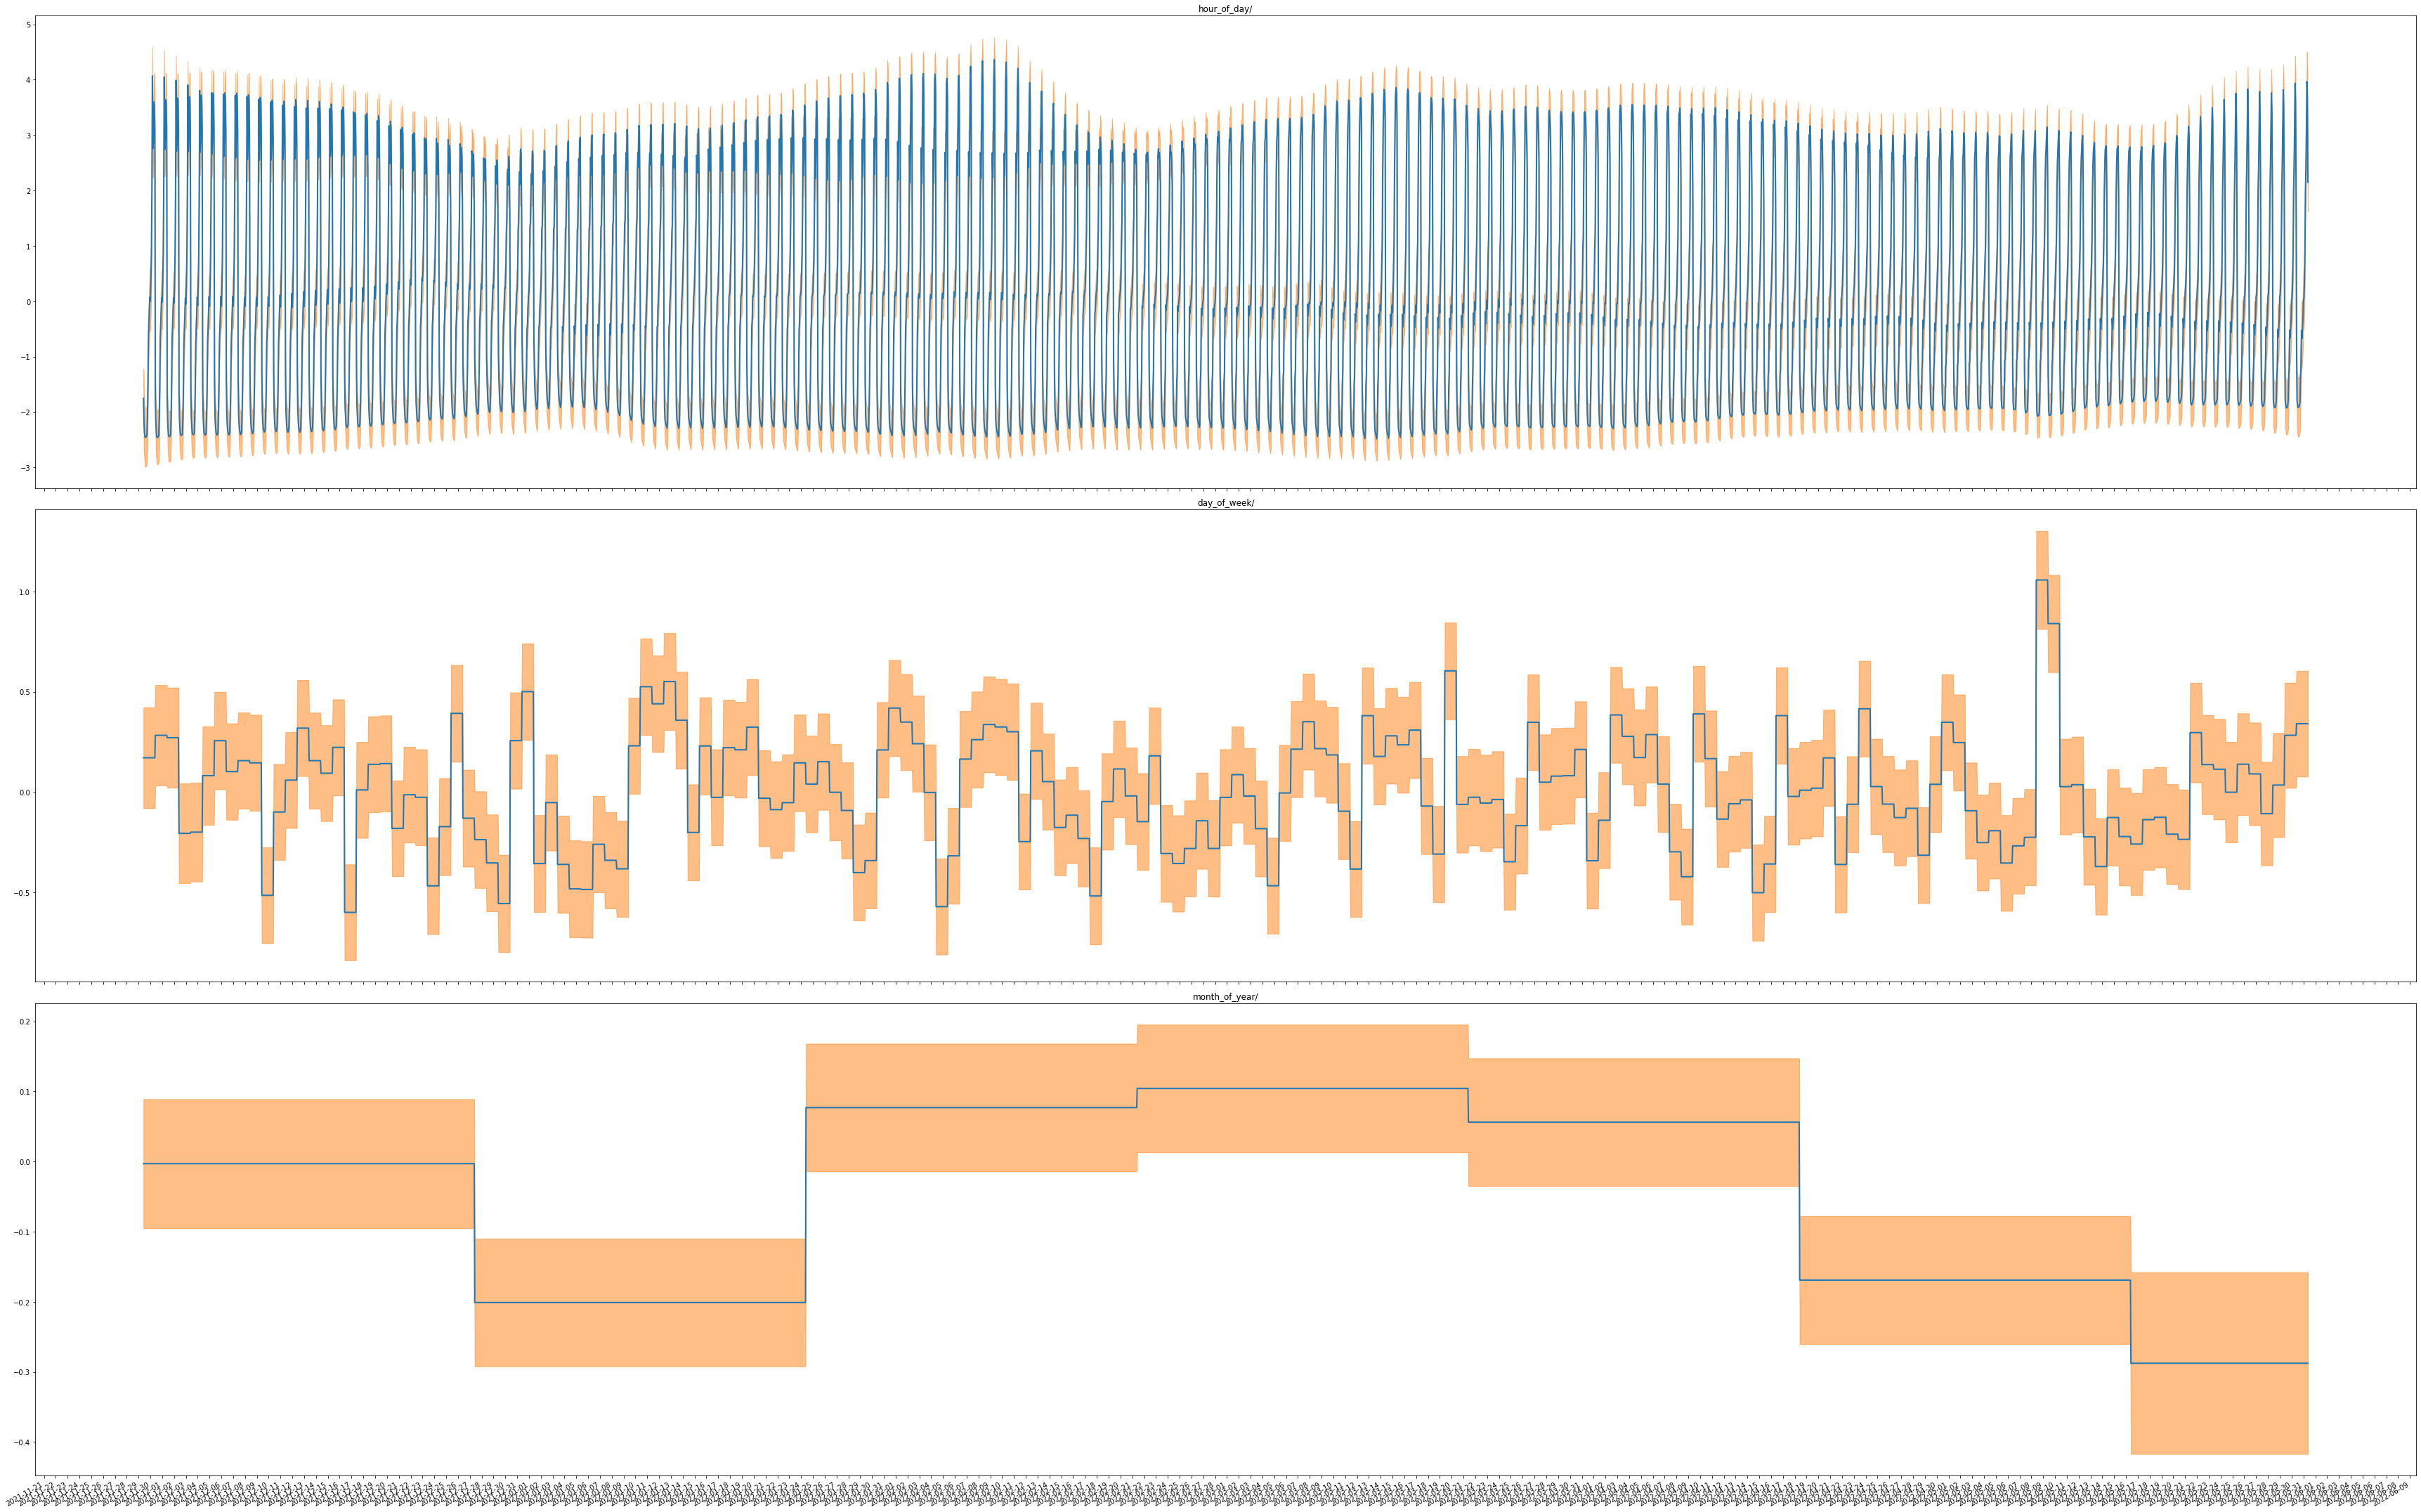

In [161]:
decomposition = plot_components(df_res.time, component_means_, component_stddevs_, x_locator=loc, x_formatter=fmt)